In [1]:
import json
import os
import time
from VIPurPCAvsMC import *
from utils import *
import jax.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA as pca_sklearn

In [41]:
#def cvp(jvp_fun, vjp_fun, X_flat, X_unflattener, C_flat, n, p, p_keep, i):
#    v1 = np.ravel(jax.nn.one_hot(np.array([i]), min(n, p_keep)*p))
#    v2 = vjp_fun(v1)[0]
#    v3 = np.multiply(v2, C_flat)
#    v4 = jvp_fun(v3)
#    return v4

In [26]:
X = np.load('../data/macrophage/mean.npy')
X = X - np.mean(X, axis=0)
X_flat, X_unflattener = flatten_util.ravel_pytree(X)
A = np.load('../data/macrophage/A.npy')
B = np.load('../data/macrophage/B.npy')
A = A + 1e-3*np.eye(A.shape[0])
B = B + 1e-3*np.eye(B.shape[0])
#C = np.load('../data/macrophage/var.npy')
#C = np.maximum(C, 1e-6)
#C_flat, C_unflattener = flatten_util.ravel_pytree(C)

In [27]:
p_keep=10
n, p = X.shape
start = time.time()
print('Start PCA')
V = pca(X_flat, X_unflattener, p_keep)
#V = np.reshape(V, (p_keep, p), 'C')
#T = np.dot(X, np.transpose(V))
# VIPurPCA
f = lambda X: pca(X, X_unflattener, p_keep)
_, f_vjp = vjp(f, X_flat)
_, f_jvp = jax.linearize(f, X_flat)
cvp_fun = lambda s: cvp(f_jvp, f_vjp, X_flat, X_unflattener, A, B, n, p, p_keep, s)
#C = np.array([cvp_fun(i) for i in range(min(n, p_keep)*p)])
#C = map(cvp_fun, np.arange(min(n, p_keep)*p))
#C = map(cvp_fun, np.arange(1))
batch_size = 1000
b = batch(np.arange(min(n, p_keep)*p), batch_size)
C_output = np.vstack([vmap(cvp_fun)(i) for i in b])
#C = vmap(cvp_fun)(np.arange(min(n, p_keep)*p))
end = time.time()
print(end-start)
# Monte-Carlo
n_iter = 1000
Vs = MC(X_flat, X_unflattener, A, B, p_keep, n_iter, batch_size)
Vs = vmap(outer_function_correcting, (0, None), 0)(Vs, np.reshape(V, (min(n, p_keep), p), 'C'))
T_mcs = np.array([X @ np.transpose(i) for i in Vs])
Vs = vmap(lambda x: np.ravel(x, 'C'))(Vs)
C_mc = np.cov(np.transpose(Vs))

Start PCA
49.76876139640808


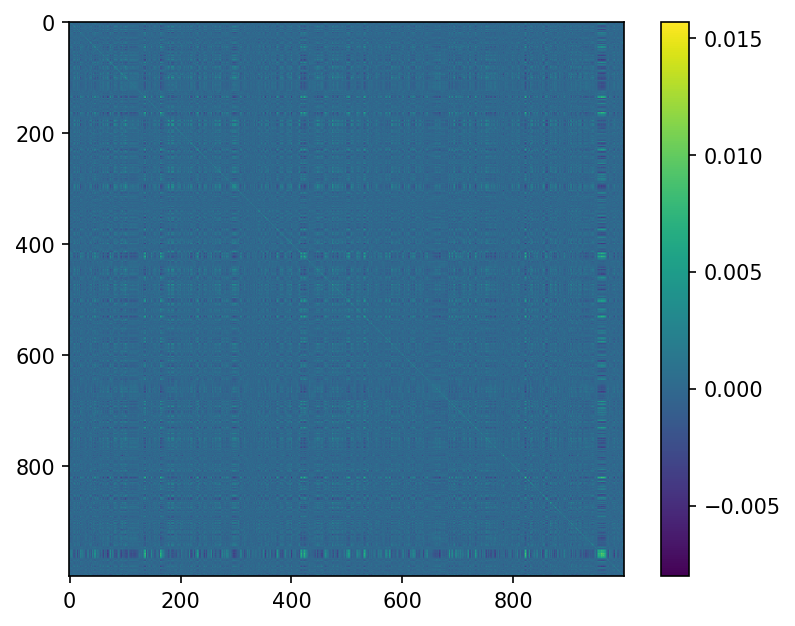

In [23]:
plt.imshow(C_output[1000:2000, 1000:2000])
plt.colorbar()

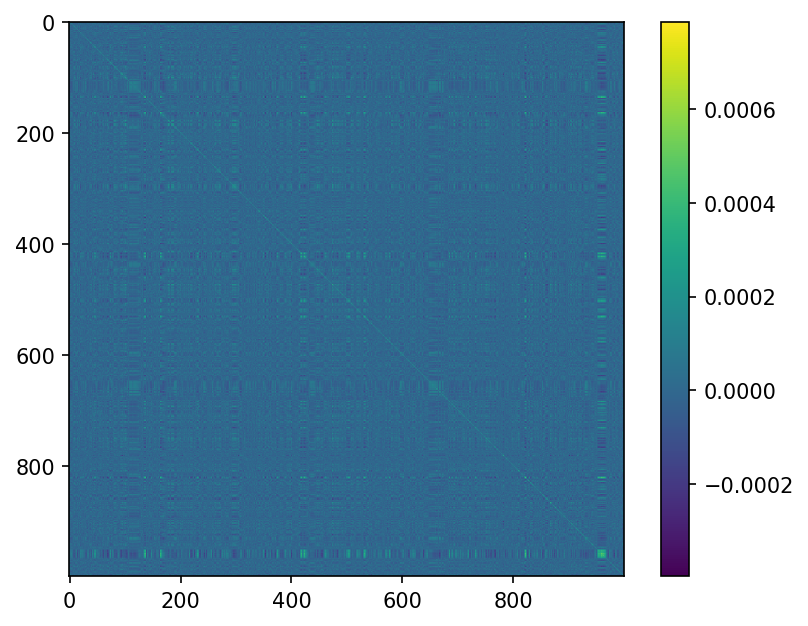

In [28]:
plt.imshow(C_mc[1000:2000, 1000:2000])
plt.colorbar()

In [9]:
metadata = pd.read_csv('../data/macrophage/metadata.txt', sep=' ', header=0, index_col=0)
metadata.head()

,names,id,line,condition,files
1,SAMEA103885102,diku_A,diku_1,naive,/Library/Frameworks/R.framework/Versions/4.2/R...
2,SAMEA103885347,diku_B,diku_1,IFNg,/Library/Frameworks/R.framework/Versions/4.2/R...
3,SAMEA103885043,diku_C,diku_1,SL1344,/Library/Frameworks/R.framework/Versions/4.2/R...
4,SAMEA103885392,diku_D,diku_1,IFNg_SL1344,/Library/Frameworks/R.framework/Versions/4.2/R...
5,SAMEA103885182,eiwy_A,eiwy_1,naive,/Library/Frameworks/R.framework/Versions/4.2/R...


In [10]:
le = LabelEncoder()
labels = le.fit_transform(metadata['condition'].values)
labels2 = le.fit_transform(metadata['line'].values)
m = ["o", "v", "x", "+", "1"]

In [11]:
n_iter = 100
key = jax.random.PRNGKey(42)
V_drawn = jax.random.multivariate_normal(key, V, C_output+1e-4*np.eye(V.shape[0]), shape=(n_iter,))
T_s = np.array([X @ np.transpose(np.reshape(i, (p_keep, p), 'C')) for i in V_drawn])

In [50]:
np.sum(V_drawn)

DeviceArray(807.7727, dtype=float32)

In [25]:
print(Vs)

[[nan nan nan ... -0. -0. -0.]
 [nan nan nan ... -0. -0. -0.]
 [nan nan nan ... -0. -0. -0.]
 ...
 [nan nan nan ... -0. -0. -0.]
 [nan nan nan ... -0. -0. -0.]
 [nan nan nan ... -0. -0. -0.]]


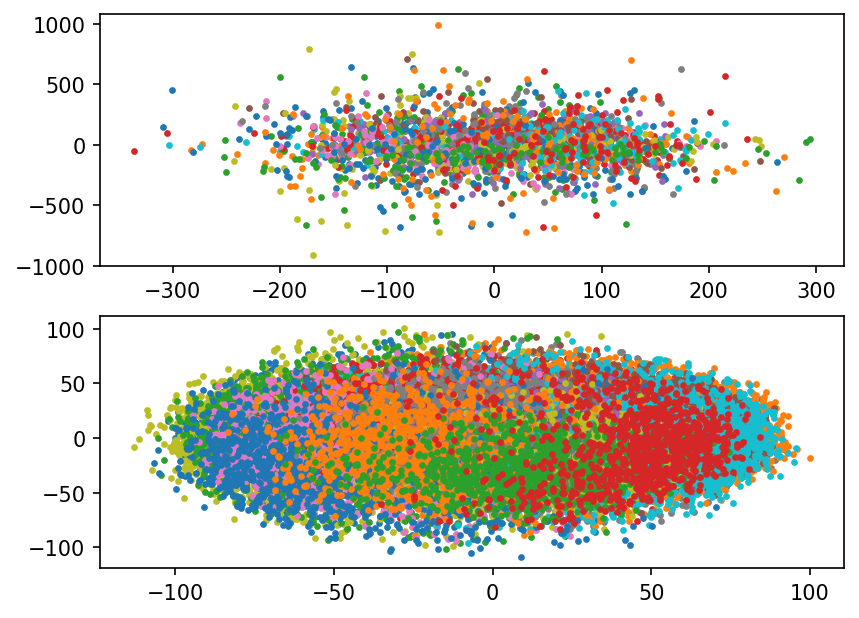

In [29]:
f, (ax1, ax2) = plt.subplots(2)
pcx, pcy = (0, 1)
for j in range(n):
    ax1.scatter(x=T_s[:, j, pcx], y=T_s[:, j, pcy], s=5)#, c=['C'+str(labels[j]) for i in range(n_iter)])#, marker=m[labels2[j]], alpha=.5)
    ax2.scatter(x=T_mcs[:, j, pcx], y=T_mcs[:, j, pcy], s=5)

In [33]:
pca_control = pca_sklearn()
T = pca_control.fit_transform(X)

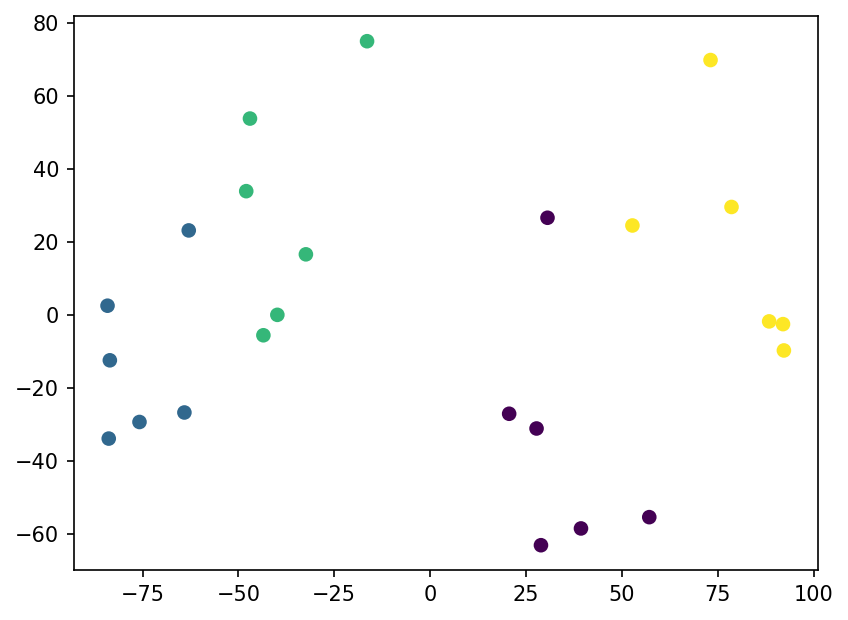

In [34]:
plt.scatter(T[:, 0], T[:, 1], c=labels)